# 2022-02-07 • Big-N-to-1 simulation

In [1]:
# Pkg.resolve()

In [2]:
include("nb_init.jl")

[ Info: using Revise
[ Info: import Distributions
[ Info: import PyPlot
[ Info: import DataFrames, PrettyTables
[ Info: import MyToolbox, Sciplotlib
[ Info: using VoltageToMap


In [3]:
using Parameters, ComponentArrays
@alias CVec = ComponentVector;

In [4]:
save(fname) = savefig(fname, subdir="methods");

## Parameters

In [5]:
sim_duration = 2 * seconds
Δt           = 0.1 * ms;   # Size of first step only, given that solver has adaptive timestep.

### Input spikers

In [6]:
N_unconn = 100
N_exc    = 5200
N_inh    = N_exc ÷ 4

N_unconn = 100
N_exc    = 800
N_inh    = N_exc ÷ 4

200

In [7]:
N_conn = N_inh + N_exc

1000

In [8]:
N = N_conn + N_unconn

1100

In [9]:
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)  # See the previous notebook

LogNormal{Float64}(μ=1.0862943611198905, σ=0.7745966692414834)

### Synapses

Reversal potential at excitatory and inhibitory synapses,
as in the report [`2021-11-11__synaptic_conductance_ratio.pdf`](https://github.com/tfiers/phd-thesis/blob/main/reports/2021-11-11__synaptic_conductance_ratio.pdf):

In [10]:
v_exc =   0 * mV
v_inh = -65 * mV;

Synaptic conductances `g` at `t = 0`:

In [11]:
g0 = 0 * nS;

Exponential decay time constant of synaptic conductance, $τ_{s}$ (`s` for "synaptic"):

In [12]:
τ_s = 7 * ms;

Increase in synaptic conductance on a presynaptic spike.

In [13]:
Δg_exc = 0.1 * nS
Δg_inh = 0.4 * nS;

### Izhikevich neuron

Membrane potential `v` and adaptation variable `u` at `t = 0`:

In [14]:
v0    = -80 * mV
u0    =   0 * pA;

Parameters for a cortical regular spiking neuron:

In [15]:
@with_kw struct IzhikevichParams
    C      = 100 * pF
    k      = 0.7 * (nS/mV)
    b      = -2 * nS
    v_r    = -60 * mV
    v_t    = -40 * mV
    v_peak =  35 * mV
    c      = -50 * mV       # reset voltage.
    a      = 0.03 / ms      # 1 / time constant of `u`
    d      = 100 * pA       # `u` increase on spike. Free parameter.
end

cortical_RS = IzhikevichParams()

# Fix these params globally for now.
@unpack C, k, b, v_r, v_t, v_peak, c, a, d = cortical_RS;

## Neurons & synapses

IDs and mappings are simple here for the N-to-1 case: only input 'neurons' get an ID, and there is only one synapse for every (connected) neuron.

In [16]:
@alias NeuronID = Int
@alias SynapseID = Int;

See below for the behaviour of this utility function.

In [17]:
"""Given group names and numbers, build a CVec with these group names and a unique ID for each element."""
function ID_CVec(; kw...)
    transform(val::Number) = fill(-1, val)
    transform(val::CVec) = val  # allow nested ID_CVecs.
    cvec = CVec(; (key => transform(val) for (key, val) in kw)...)
    cvec .= 1:length(cvec)
    return cvec
end;

### Neuron IDs

In [18]:
neuron_ids = ID_CVec(conn = ID_CVec(exc = N_exc, inh = N_inh), unconn = N_unconn)

ComponentVector{Int64}(conn = (exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]), unconn = [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010  …  1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100])

Example usage:

In [19]:
id = N_exc + 2
id, id == neuron_ids[id] == neuron_ids.conn.inh[2], labels(neuron_ids)[id]

(802, true, "conn.inh[2]")

### Synapses

In [20]:
synapse_ids = ID_CVec(exc = N_exc, inh = N_inh)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000])

In [21]:
g0_vec = similar(synapse_ids, Float64)
g0_vec .= g0
Δg = similar(g0_vec)
Δg.exc .= Δg_exc
Δg.inh .= Δg_inh;

$E$, the reversal potential at each synapse.

In [22]:
E = similar(g0_vec)
E.exc .= v_exc
E.inh .= v_inh
E

ComponentVector{Float64}(exc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], inh = [-0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065  …  -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065, -0.065])

### Connections

In [23]:
postsynapses = Dict{NeuronID, Vector{SynapseID}}()

for (n,s) in zip(neuron_ids.conn, synapse_ids)
    postsynapses[n] = [s]
end
for n in neuron_ids.unconn
    postsynapses[n] = []
end

## Sim

### ISI distributions

Generate firing rates $λ$ by sampling from the input spike rate distribution.

In [24]:
λ = rand(input_spike_rate, N)
showsome(λ)

1100-element Vector{Float64}:
    1: 4.628826007327454
    2: 1.9344063864708823
    ⋮
  109: 2.2705807812043237
    ⋮
 1027: 2.379919163447606
    ⋮
 1099: 4.906572087058904
 1100: 2.540831771557534


`Distributions.jl` uses alternative Exp parametrisation with scale $β$ = 1 / rate.

In [25]:
β = 1 ./ λ
ISI_distributions = Exponential.(β);
#   This uses julia's broadcasting `.` syntax: make an `Exponential` distribution for every value in the β vector

### Init spike times

Generate the first spike time for every input neuron by sampling once from its ISI distribution.

In [26]:
first_spiketimes = rand.(ISI_distributions);

Sort these initial spike times by building a priority queue.

In [27]:
upcoming_input_spikes = PriorityQueue{NeuronID, Float64}()

for (neuron_ID, t) in enumerate(first_spiketimes)
    enqueue!(upcoming_input_spikes, neuron_ID => t)
end

Check the top of the heap to find the first spiker.

In [28]:
_, next_input_spike_time = peek(upcoming_input_spikes)
    # We `peek`, and not `dequeue_pair!`, to make this cell idempotent.

661 => 0.00020980782128926102

### Differential equations

In [29]:
using OrdinaryDiffEq

The derivative function that defines the continuous differential equations:

In [30]:
function f(D, vars, _, _)
    @unpack v, u, g = vars
    I_s = sum(g .* (v .- E))
    D.v = (k * (v - v_r) * (v - v_t) - u - I_s) / C
    D.u = a * (b * (v - v_r) - u)
    D.g = -g ./ τ_s_vec
    return nothing
end;

For the sum of synaptic currents, $I_s$, note that membrane current is by convention positive
if positive charges are flowing out of the cell.
For *e.g.* v = $-80$ mV and E = $0$ mV (excitatory synapse), we get negative $I_s$, i.e. charges flowing in ✅.

The below are optimisations after profiling.

In [31]:
τ_s_vec = fill(τ_s, N_conn);

### Events

In [32]:
events = (
    thr_crossing          = 1,
    input_spike_generated = 2,
)

function update_distance_to_next_event(distance, vars, t, integrator)
    v = vars.v
    p = integrator.p  # params
    distance[events.thr_crossing]          = v - v_peak
    distance[events.input_spike_generated] = t - p.next_input_spike_time
end

function on_event(integrator, event)
    vars = integrator.u
    @unpack p, t = integrator  # params, time

    if event == events.thr_crossing
        # The discontinuous LIF/Izhikevich/AdEx update
        vars.v = c
        vars.u += d

    elseif event == events.input_spike_generated
        # Process the neuron that just fired. Start by removing it from the queue.
        fired_neuron = dequeue!(upcoming_input_spikes)
        # Generate a new spike time, and add it to the queue.
        new_spike_time = t + rand(ISI_distributions[fired_neuron])
        enqueue!(upcoming_input_spikes, fired_neuron => new_spike_time)
        # Update the downstream synapses (one or zero in the N-to-1 case).
        # Also note: no tx delay.
        for syn in postsynapses[fired_neuron]
            vars.g[syn] += Δg[syn]
        end
        # Update params: retrieve the next earliest spike.
        _, p.next_input_spike_time = peek(upcoming_input_spikes)
    end
end;

### Run simulation

Bring it all together (initial conditions, derivatives function, events) and solve.

In [33]:
vars_t0 = CVec{Float64}(v = v0, u = u0, g = g0_vec)
    # Note the cast to float (which is btw recursive), so that vars are float during sim.

ComponentVector{Float64}(v = -0.08, u = 0.0, g = (exc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], inh = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

In [34]:
params = CVec(; next_input_spike_time)

ComponentVector{Float64}(next_input_spike_time = 0.00020980782128926102)

In [35]:
using ProfileView

In [ ]:
prob = ODEProblem(f, vars_t0, float(sim_duration), params)
    # Duration must be float too, so that `t` variable is float.

solv() = solve(
    prob,
    Tsit5();          # The default and recommended solver. A Runge-Kutta method. Tsitouras 2011.
    dt = Δt,          # Size of first step.
    adaptive = true,  # Take larger steps when output is steady.
    reltol = 1e-8,    # default: 1e-2
    abstol = 1e-8,    # default: 1e-6
    callback = VectorContinuousCallback(update_distance_to_next_event, on_event, length(events)),
    save_idxs = [1,2],   # don't save all synapses
)
@profileview @time solv()
# sol = @time solv();

Tolerances are from https://diffeq.sciml.ai/stable/tutorials/ode_example/#Choosing-a-Solver-Algorithm and experimentation:
Lower for either gives incorrect oscillations in steady state (non-todo: show this in a separate nb).

In [332]:
using Sciplotlib

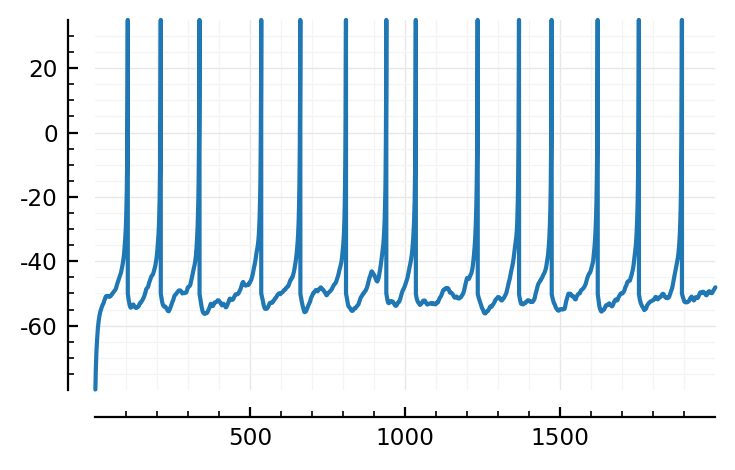

In [333]:
tzoom = sol.t[[1,end]]
# tzoom = [200, 600] .* ms
zoom = first(tzoom) .< sol.t .< last(tzoom)
plot(sol.t[zoom]/ms, sol[1,zoom]/mV, clip_on=false);